In [ ]:
! pip install pyautogui pillow matplotlib easyocr

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


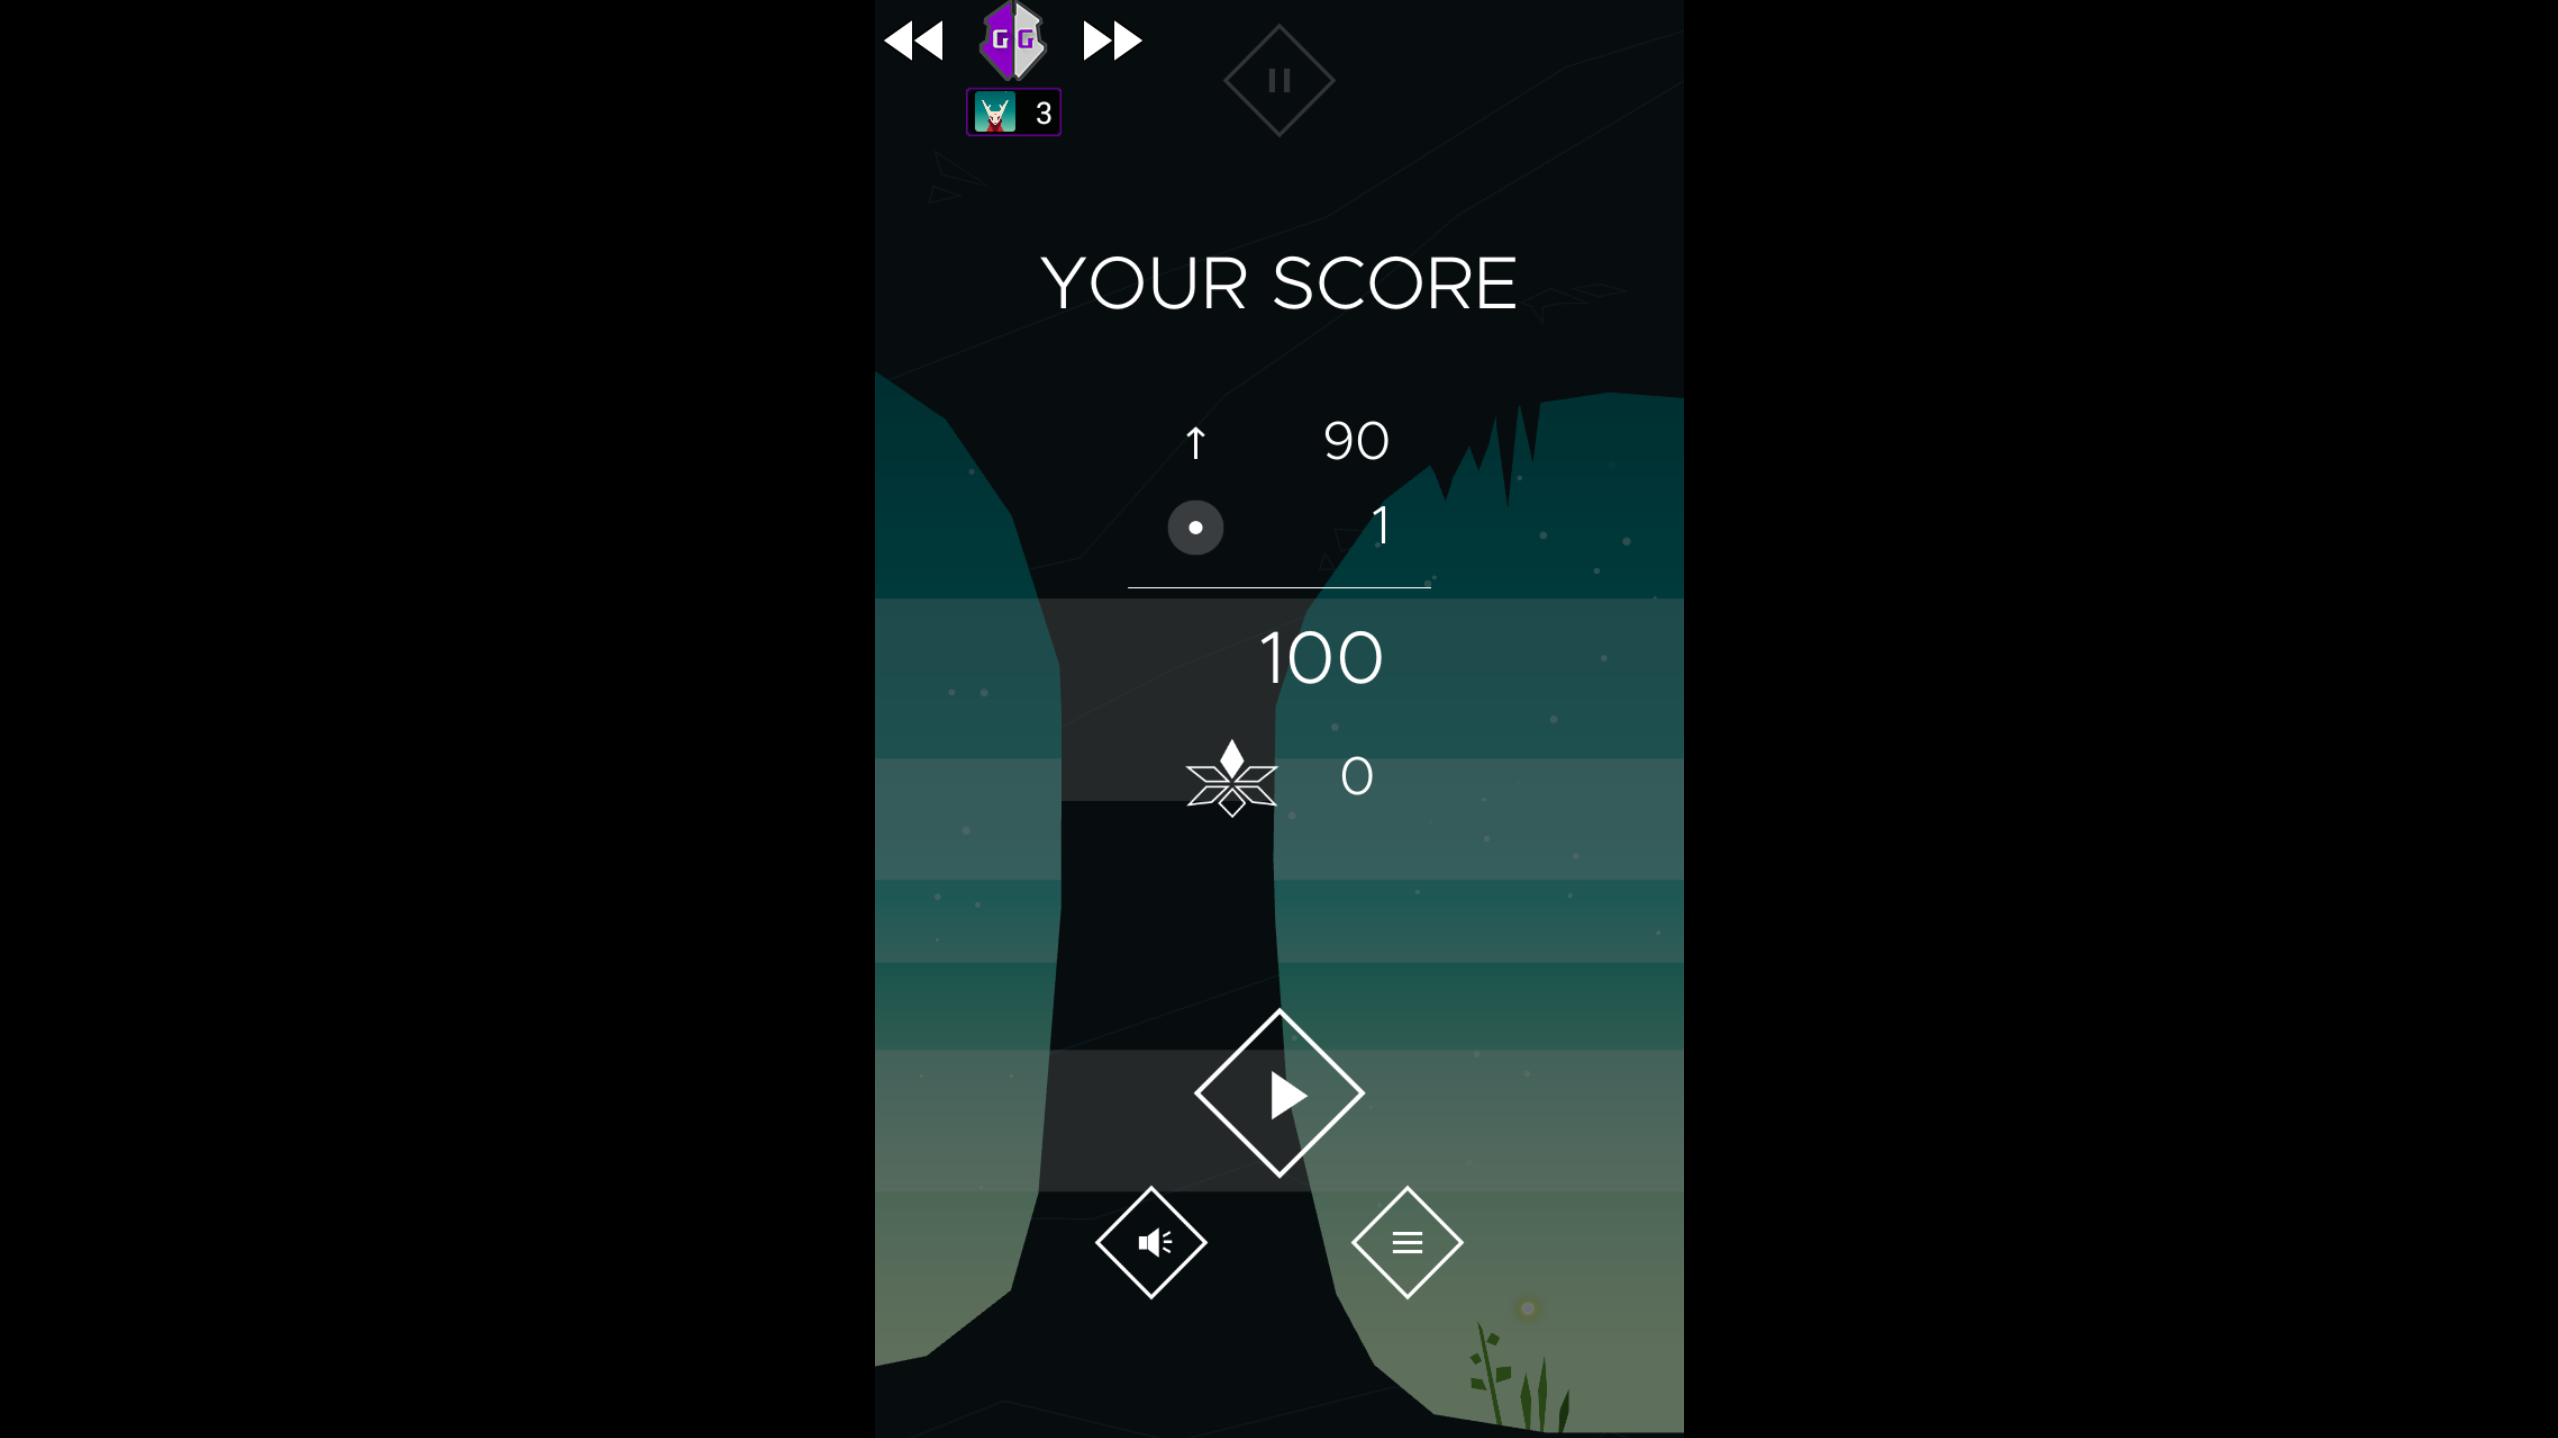

In [3]:
import pyautogui

screenshot = pyautogui.screenshot()
width, height = screenshot.size
screenshot = screenshot.crop((1, 1, width-1, height-1))
screenshot

In [4]:
import numpy as np

np.array(screenshot).shape

(1438, 2558, 3)

In [5]:
screenshot_bw = screenshot.convert("L") 

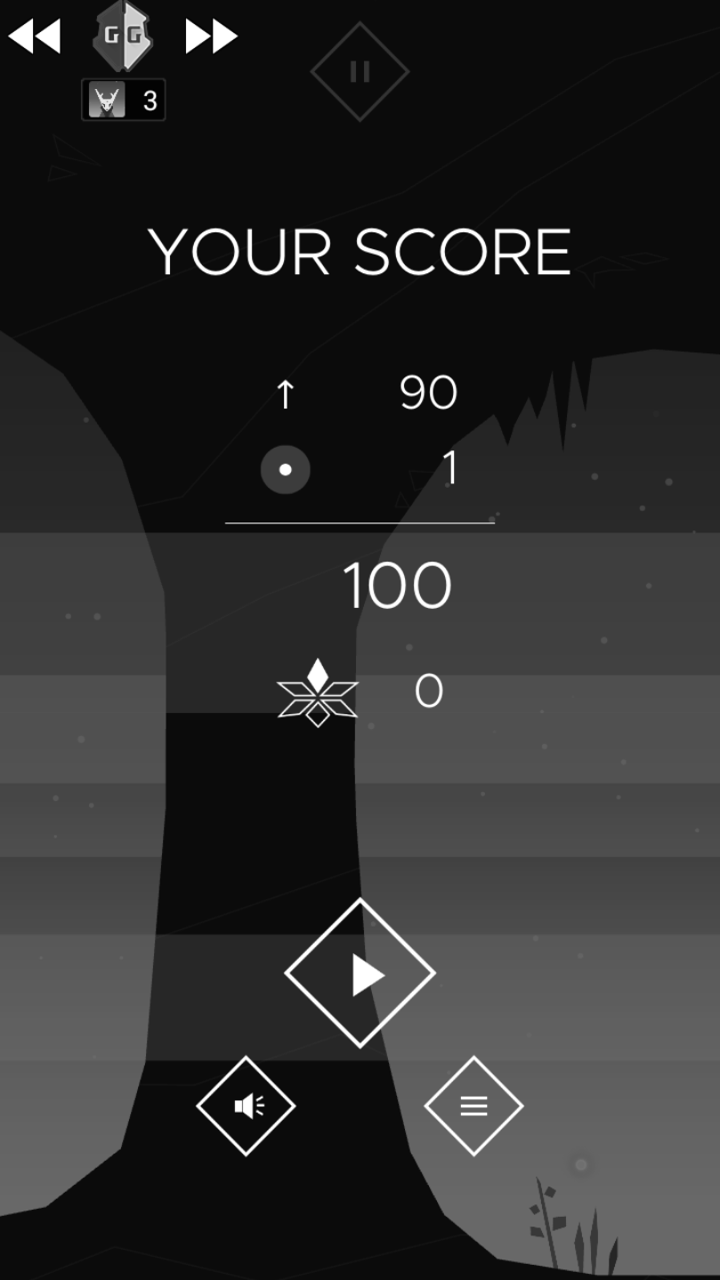

In [17]:
from PIL import Image

dest_size = (720, 1280)
screenshot_bw_np = np.array(screenshot_bw)
non_zero_columns = np.any(screenshot_bw_np != 0, axis=0)
screen_only_np = screenshot_bw_np[:, non_zero_columns]
screen_only = Image.fromarray(screen_only_np)
screen_only = screen_only.resize(dest_size)
screen_only

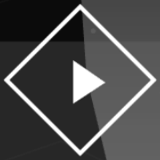

In [32]:
screenshot = screen_only
play_x, play_y = 360, 973
d = 80
x_start, x_end, y_start, y_end = play_x - d, play_x + d, play_y - d, play_y + d
cropped_image = screenshot.crop((x_start, y_start, x_end, y_end))
cropped_image

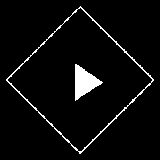

In [34]:
cropped_image_np = np.array(cropped_image)
cropped_image_np_mask = np.where(cropped_image_np == 255, 255, 0).astype('uint8')
cropped_image = Image.fromarray(cropped_image_np_mask)
cropped_image

In [51]:
def take_screen_shot():
    dest_size = (720, 1280)
    screenshot = pyautogui.screenshot()
    width, height = screenshot.size
    screenshot = screenshot.crop((1, 1, width-1, height-1)).convert("L") 
    screenshot_bw_np = np.array(screenshot)
    non_zero_columns = np.any(screenshot_bw_np != 0, axis=0)
    screen_only_np = screenshot_bw_np[:, non_zero_columns]
    screen_only = Image.fromarray(screen_only_np).resize(dest_size)
    return screen_only

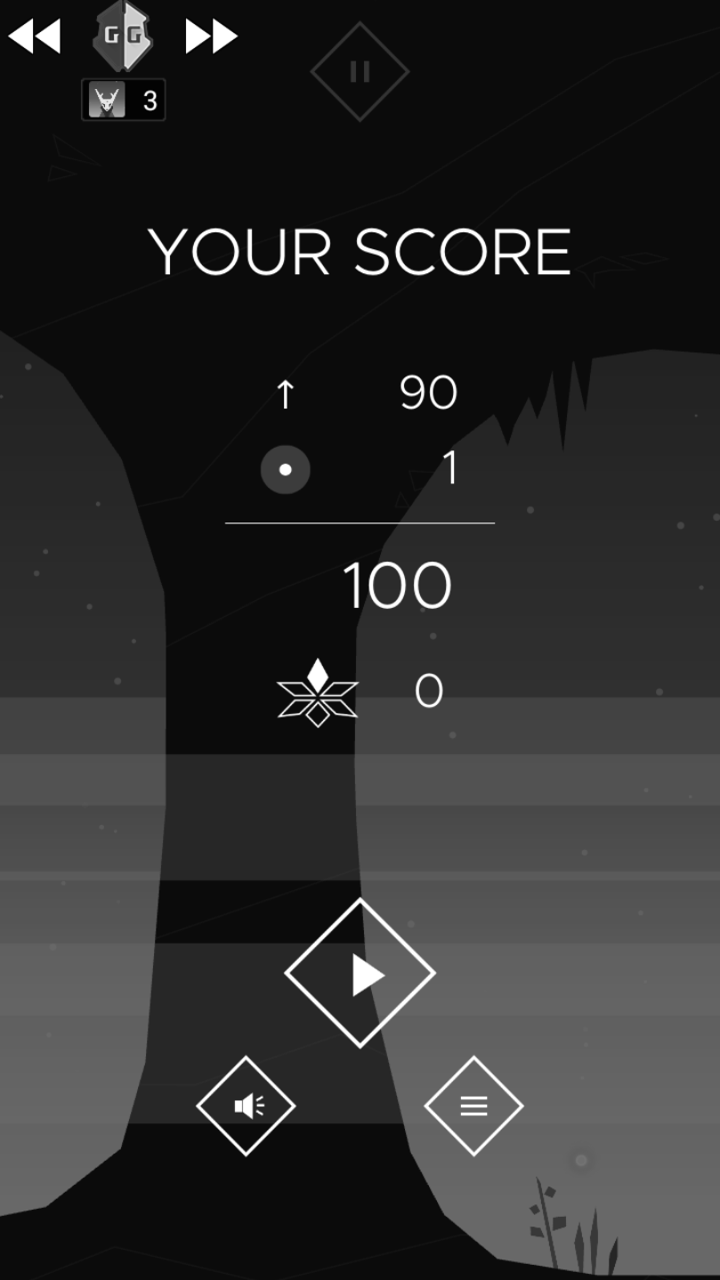

In [52]:
screenshot = take_screen_shot()
screenshot

In [57]:
def extract_whites(image):
    image_np = np.array(image)
    image_np_mask = np.where(image_np == 255, 255, 0).astype('uint8')
    return image_np_mask

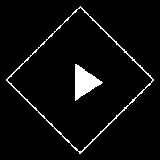

In [58]:
play_x, play_y = 360, 973
d = 80
x_start, x_end, y_start, y_end = play_x - d, play_x + d, play_y - d, play_y + d
cropped_image = screenshot.crop((x_start, y_start, x_end, y_end))
play_button_image = Image.fromarray(extract_whites(cropped_image))
play_button_image

In [59]:
play_button_image.save("base_images/play_button_bin.png")

In [65]:
def is_endgame_screen(screenshot: Image, play_image_pattern: Image, possible_fails:int = 50):
    possible_fails = 50
    play_x, play_y = 360, 973 # play button center
    d = 80
    x_start, x_end, y_start, y_end = play_x - d, play_x + d, play_y - d, play_y + d
    cropped_image = screenshot.crop((x_start, y_start, x_end, y_end))
    screenshot_wo_np = extract_whites(cropped_image)
    
    play_image_pattern_np = np.array(play_image_pattern).astype('uint8')
    bool_mask = screenshot_wo_np == play_image_pattern_np
    if np.sum(bool_mask == False) < possible_fails:
        return True

    return False

In [96]:
is_endgame_screen(take_screen_shot(), play_button_image)

True

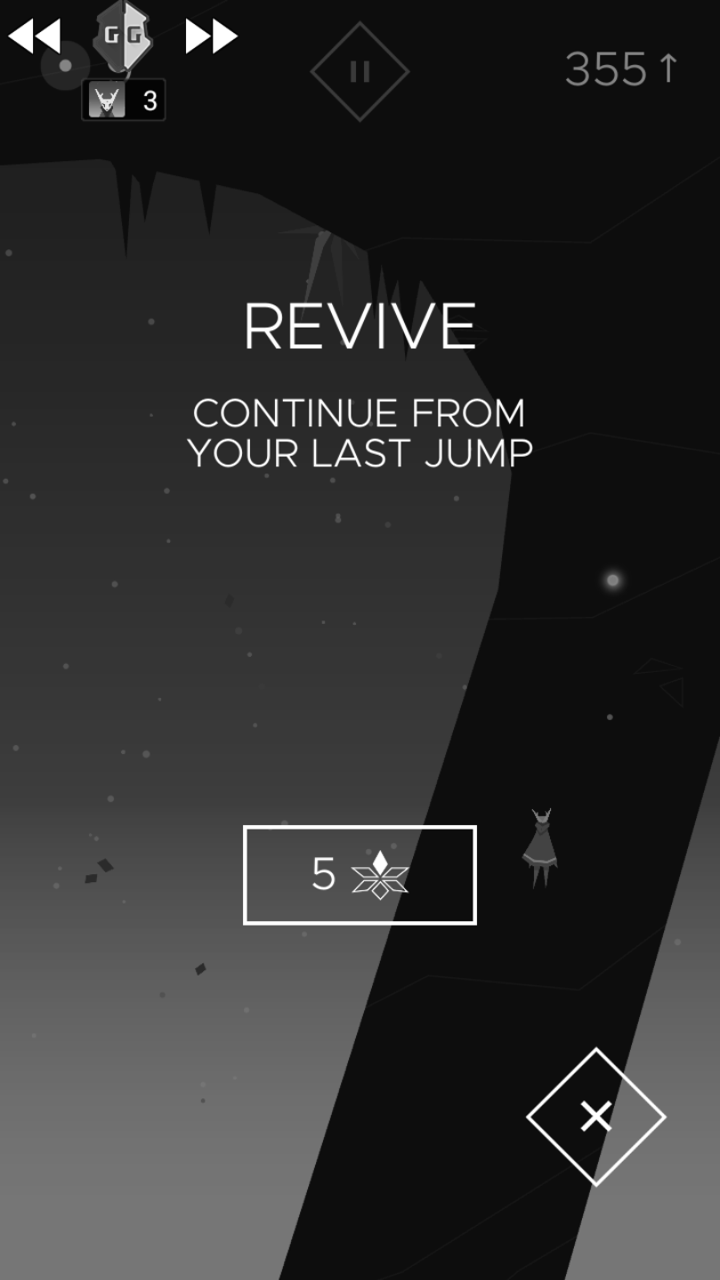

In [69]:
screenshot = take_screen_shot()
screenshot

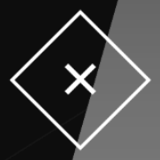

In [87]:
close_x, close_y = 596, 1117
d = 80
x_start, x_end, y_start, y_end = close_x - d, close_x + d, close_y - d, close_y + d
cropped_image = screenshot.crop((x_start, y_start, x_end, y_end))
cropped_image

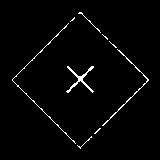

In [88]:
close_button_image = Image.fromarray(extract_whites(cropped_image))
close_button_image

In [89]:
close_button_image.save("base_images/close_button_bin.png")

In [90]:
def is_revive_screen(screenshot: Image, close_image_pattern: Image, possible_fails:int = 50):
    possible_fails = 50
    close_x, close_y = 596, 1117 # close button center
    d = 80
    x_start, x_end, y_start, y_end = close_x - d, close_x + d, close_y - d, close_y + d
    cropped_image = screenshot.crop((x_start, y_start, x_end, y_end))
    screenshot_wo_np = extract_whites(cropped_image)
    
    close_image_pattern_np = np.array(close_image_pattern).astype('uint8')
    bool_mask = screenshot_wo_np == close_image_pattern_np
    if np.sum(bool_mask == False) < possible_fails:
        return True

    return False

In [99]:
is_revive_screen(take_screen_shot(), close_button_image)

True

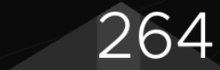

In [131]:
x_start, x_end, y_start, y_end = 240, 460, 550, 620
cropped_image = screenshot.crop((x_start, y_start, x_end, y_end))
cropped_image

In [134]:
import easyocr
from PIL import Image
reader = easyocr.Reader(['en'])

def extract_results_from_ss(screenshot, reader=reader):
    x_start, x_end, y_start, y_end = 240, 460, 550, 620
    result_img = screenshot.crop((x_start, y_start, x_end, y_end))
    result = reader.readtext(np.array(result_img))
    numbers = ''.join([text[1] for text in result if text[1].isdigit()])

    try:
        numbers = int(numbers)
        return numbers
    except:
        return -1

In [135]:
extract_results_from_ss(screenshot)

264

In [262]:
import easyocr
import pyautogui
import random
import time
import threading
from PIL import Image


class FernFlowerEnv():
    def __init__(self, close_image_path: str, play_image_path: str, game_speed: int = 1):
        self.reader = easyocr.Reader(['en'])
        self.dest_ss_size = (720, 1280)
        self.close_image_pattern_np = np.array(Image.open(close_image_path)).astype('uint8')
        self.close_button_center = (596, 1117)
        self.play_image_pattern_np = np.array(Image.open(play_image_path)).astype('uint8')
        self.play_button_center = (360, 973)
        self.d = 80
        self.accepted_fails = 50
        
        screen_width, screen_height = pyautogui.size()
        self.play_button_position = (int(0.5 * screen_width), int(0.75 * screen_height))
        self.close_button_position = (int(0.6 * screen_width), int(0.87 * screen_height))

        self.game_speed = game_speed
        self.jump_time_dict = {
            'no_jump': 0,
            'short': 0.05/game_speed,
            'medium': 0.15/game_speed,
            'long': 0.3/game_speed
        }

        self.jump_time_codes = list(self.jump_time_dict.keys()) 
        self.directions = ['left', 'right']
        self.reload_gui_time_buffer = 1/game_speed

    def take_screenshot(self):
        screenshot = pyautogui.screenshot()
        width, height = screenshot.size
        screenshot = screenshot.crop((1, 1, width-1, height-1)).convert("L") 
        screenshot_bw_np = np.array(screenshot)
        non_zero_columns = np.any(screenshot_bw_np != 0, axis=0)
        screen_only_np = screenshot_bw_np[:, non_zero_columns]
        screen_only = Image.fromarray(screen_only_np).resize(self.dest_ss_size)
        return screen_only

    @staticmethod
    def extract_whites(image):
        image_np_mask = np.where(np.array(image) == 255, 255, 0).astype('uint8')
        return image_np_mask
        
    def extract_results_from_ss(self, screenshot):
        x_start, x_end, y_start, y_end = 240, 460, 550, 620
        result_img = screenshot.crop((x_start, y_start, x_end, y_end))
        result = self.reader.readtext(np.array(result_img))
        numbers = ''.join([text[1] for text in result if text[1].isdigit()])
    
        try:
            numbers = int(numbers)
            return numbers
        except:
            return -1

    def compare_image_with_pattern(self, cropped_image_np, pattern_np):
        screenshot_wo_np = self.extract_whites(cropped_image_np)
        bool_mask = screenshot_wo_np == pattern_np
        if np.sum(bool_mask == False) < self.accepted_fails:
            return True
        return False

    def is_revive_screen(self, screenshot: Image, possible_fails:int = 50):
        close_x, close_y = self.close_button_center
        x_start, x_end, y_start, y_end = close_x - self.d, close_x + self.d, close_y - self.d, close_y + self.d
        cropped_image_np = screenshot.crop((x_start, y_start, x_end, y_end))
        return self.compare_image_with_pattern(cropped_image_np, self.close_image_pattern_np)

    def is_endgame_screen(self, screenshot: Image, possible_fails:int = 50):
        play_x, play_y = self.play_button_center     
        x_start, x_end, y_start, y_end = play_x - self.d, play_x + self.d, play_y - self.d, play_y + self.d 
        cropped_image_np = screenshot.crop((x_start, y_start, x_end, y_end))
        return self.compare_image_with_pattern(cropped_image_np, self.play_image_pattern_np)

    @staticmethod
    def click(coordinates):
        pyautogui.click(*coordinates)
    
    def jump(self, direction, time_code):
        jump_time_float = self.jump_time_dict[time_code]
        pyautogui.keyDown(direction)
        time.sleep(jump_time_float)
        pyautogui.keyUp(direction)

    def jump_in_background(self, direction, time_code):
        thread = threading.Thread(target=self.jump, args=(direction, time_code))
        thread.start()
        return thread 

    def check_game_end(self):
        screenshot = self.take_screenshot()
        if self.is_revive_screen(screenshot):
            self.click(self.close_button_position)
            time.sleep(self.reload_gui_time_buffer)
                
        if self.is_endgame_screen(screenshot):
            time.sleep(self.reload_gui_time_buffer)
            results_screenshot = self.take_screenshot()
            result = extract_results_from_ss(results_screenshot)
            self.click(self.play_button_position)
            time.sleep(self.reload_gui_time_buffer)
            return True, result
            
        return False, 0

    def check_game_end_in_background(self):
        result = [None]
        def worker():
            result[0] = self.check_game_end()
        thread = threading.Thread(target=worker)
        thread.start()
        return thread, result

    def run(self):
        self.click(self.close_button_position)
        time.sleep(self.reload_gui_time_buffer)
        self.click(self.play_button_position)
        time.sleep(self.reload_gui_time_buffer)

        while True:
            jump_thread = self.jump_in_background(random.choice(self.directions), random.choice(self.jump_time_codes))
            check_thread, result_container = self.check_game_end_in_background()
            jump_thread.join()
            check_thread.join()
            is_game_end, result = result_container[0]
            
            if is_game_end:
                print(f"END GAME: [{result} pts]")  



In [ ]:
ffe = FernFlowerEnv("base_images/close_button_bin.png", "base_images/play_button_bin.png", 2)
ffe.run()

In [ ]:
# memu emulator, root, gameguard speedhack x3